# Описание задачи

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Необходимо разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

# Описание данных

Данные
- train.csv - информация (около 20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
- test.csv - информация (около 5000) музыкальных треках, которые будут использоваться в качестве тестовых данных.
- sample_submit.csv - файл предсказаний в правильном формате.
- instance_id - идентификатор трека в тестовом наборе.
- music_genre - Целевой признак. Для каждого трека необходимо предсказать категориальное значение соответствующее музыкальному жанру трека.

Описание полей данных
- instance_id - уникальный идентификатор трека
- track_name - название трека
- acousticness - акустичность. Мера уверенности в том, что композиция является акустической в интервале от 0.0 до 1.0. Значение 1.0 обозначает высокую уверенность в том, что композиция акустическая.
- danceability - танцевальность. Danceability описывает пригодность дорожки для танцев на основании таких музыкальных элементов, как темп, стабильность ритма, сила долей и общее постоянство. Композиции со значением 0.0 наименее танцевальные, со значением 1.0 — наиболее танцевальные.
- duration_ms - продолжительность в милисекундах
- energy - энергичность. Это величина в интервале от 0.0 до 1.0, характеризующая критерий восприятия «яркости» и «активности» песни. Обычно энергичные композиции быстрые, громкие и шумные. Например, высокой энергией обладает death metal, а прелюдия Баха имеет по этой шкале низкие показатели.
- instrumentalness - инструментальность. Прогнозирует, что в треке нет вокала. Рэп или треки со словами очевидно являются «вокальными». Чем ближе значение инструментальности к 1.0, тем выше вероятность того, что в треке не содержится голоса.
- key
- liveness - живое исполнение. Распознаёт присутствие в записи слушателей. Чем больше значения liveness, тем выше вероятность того, что песня исполнялась вживую.
- loudness - громкость.
- mode
- speechiness - обнаруживает присутствие текста в песне. Если speechiness композиции выше 0.66, то она скорее всего состоит из текста, значение от 0.33 до 0.66 означает, что песня может содержать и музыку, и слова, а значение ниже 0.33 означает, что в песне нет никаких слов.
- tempo - темп
- obtained_date - дата загрузки в сервис
- valence - эта величина в интервале от 0.0 до 1.0 описывает музыкальную позитивность, передаваемую песней. Песни с высокой valence звучат более позитивно (т.е. они передают счастье, радость или эйфорию), а песни с низкой valence звучат негативнее (т.е. они печальные, депрессивные или гневные).
- music_genre - музыкальный жанр

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     StratifiedKFold)
from sklearn.compose import (ColumnTransformer,
                             make_column_selector)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_data = pd.read_csv('C:/Users/79276/Downloads/dataset/kaggle_music_genre_train.csv')
test_data = pd.read_csv('C:/Users/79276/Downloads/dataset/kaggle_music_genre_test.csv')

# EDA

In [5]:
display(train_data.head())
display(test_data.head())

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121


In [6]:
display(train_data.info())
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


None

In [7]:
display(len(train_data))
display(len(train_data.drop_duplicates()))

20394

20394

Полных дубликатов в датасете не обнаружено

In [8]:
train_data.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


Проверим степень корреляции признаков

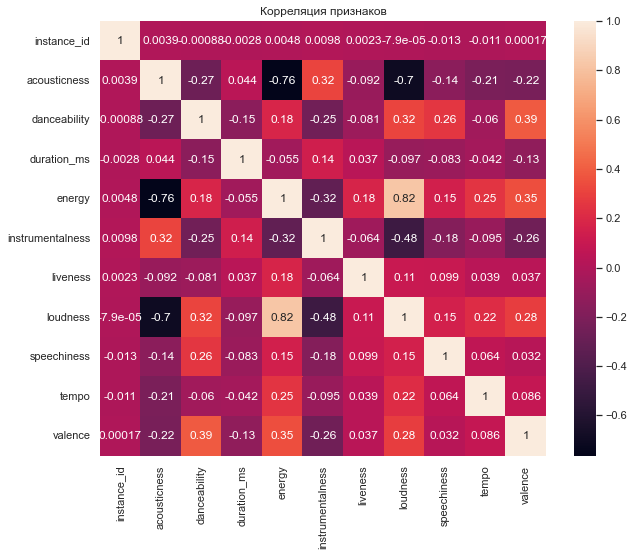

In [9]:
sns.set(rc={'figure.figsize':(10, 8)})
numeric_columns = train_data.columns[np.where(train_data.dtypes==np.number)]
sns.heatmap(train_data[numeric_columns].corr(), annot = True).set(title='Корреляция признаков')
plt.show()

Наиболее значительные корреляции: 
- energy существенно коррелирует с loudness
- acousticness имеет значительно выраженную обратную корреляцию с loudness и energy
- danceability заметно коррелирует с valence

Ознакомимся с пропусками. В обоих датафреймах они были обнаружены в столбцах key, mode, tempo. Числовой столбец tempo заполним медианой, а два остальных "заглушками" "unknown" и снова проверим датафреймы на предмет пропусков.

In [10]:
train_data.fillna(value= {'key':'unknown', 'mode':'unknown', 'tempo':train_data['tempo'].median()}, inplace = True)
test_data.fillna(value= {'key':'unknown', 'mode':'unknown', 'tempo':test_data['tempo'].median()}, inplace = True)

In [11]:
display(train_data.info())
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               20394 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              20394 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             20394 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               5099 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              5099 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             5099 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


None

Похоже, пропусков больше не осталось. Теперь посмотрим на распределения числовых признаков.

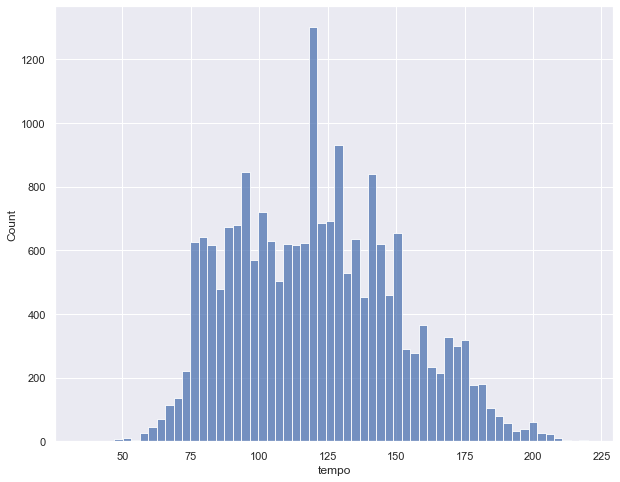

In [12]:
sns.histplot(train_data.tempo, bins = 60)
plt.show()

ValueError: num must be 1 <= num <= 10, not 11

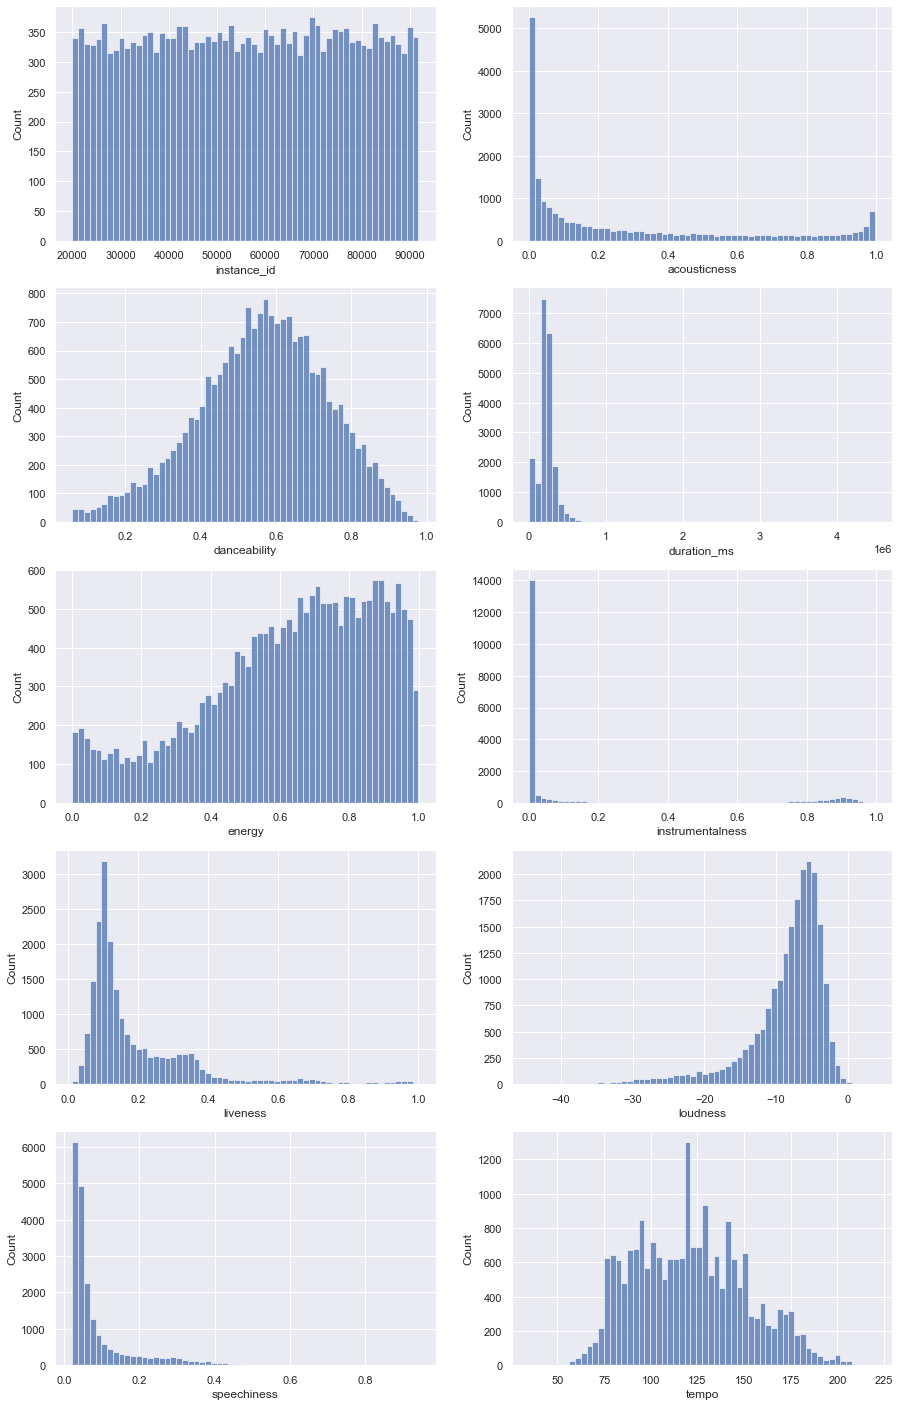

In [13]:
sns.set(rc={'figure.figsize':(15, 25)})
for x, column in enumerate(numeric_columns):
    plt.subplot(5, 2, x+1)
    sns.histplot(train_data[column], bins = 60)
    
plt.show()

In [14]:
pd.cut(train_data['acousticness'], bins = 10).value_counts(normalize = True)

(-0.000996, 0.0996]    0.473620
(0.0996, 0.199]        0.111552
(0.896, 0.996]         0.087771
(0.199, 0.299]         0.073943
(0.299, 0.398]         0.057615
(0.398, 0.498]         0.046631
(0.498, 0.598]         0.039619
(0.598, 0.697]         0.037364
(0.797, 0.896]         0.036776
(0.697, 0.797]         0.035108
Name: acousticness, dtype: float64

In [15]:
pd.cut(train_data['instrumentalness'], bins = 10).value_counts(normalize = True)

(-0.000996, 0.0996]    0.756203
(0.797, 0.896]         0.055899
(0.896, 0.996]         0.051976
(0.0996, 0.199]        0.029764
(0.697, 0.797]         0.025645
(0.598, 0.697]         0.019417
(0.199, 0.299]         0.019123
(0.498, 0.598]         0.015642
(0.398, 0.498]         0.013288
(0.299, 0.398]         0.013043
Name: instrumentalness, dtype: float64

In [16]:
pd.cut(train_data['duration_ms'], bins = 10).value_counts(normalize = True)

(-4498.995, 449798.5]     0.969648
(449798.5, 899598.0]      0.027900
(899598.0, 1349397.5]     0.001765
(1349397.5, 1799197.0]    0.000490
(4048194.5, 4497994.0]    0.000098
(2698796.0, 3148595.5]    0.000049
(1799197.0, 2248996.5]    0.000049
(3598395.0, 4048194.5]    0.000000
(3148595.5, 3598395.0]    0.000000
(2248996.5, 2698796.0]    0.000000
Name: duration_ms, dtype: float64

In [17]:
train_data[train_data['duration_ms']<=0]['duration_ms'].count()

2009

Показатели длительности менее секунды могут быть отнесены к неявным пропускам, можно так же заполнить их медианным значением

In [18]:
train_data.loc[train_data['duration_ms']<=0, 'duration_ms'] = None
train_data.fillna(train_data['duration_ms'].median(), inplace = True)

test_data.loc[test_data['duration_ms']<=0, 'duration_ms'] = None
test_data.fillna(test_data['duration_ms'].median(), inplace = True)

In [19]:
train_data['mode'].value_counts()


Major      12828
Minor       7060
unknown      506
Name: mode, dtype: int64

In [20]:
train_data['key'].value_counts()

G          2304
C          2149
C#         2125
D          2110
A          2013
F          1616
B          1522
E          1516
G#         1268
A#         1224
F#         1206
unknown     735
D#          606
Name: key, dtype: int64

In [21]:
train_data['music_genre'].value_counts()

Blues          2858
Alternative    2601
Electronic     2564
Rap            2428
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64

In [22]:
for column in train_data.drop(columns=['music_genre']).columns:
    if train_data[column].dtype == 'object':
        train_data[column] = train_data[column].astype('category')
        test_data[column] = test_data[column].astype('category')

Инсайты:
• В распределении показателя acousticness сосредоточение возле нуля - многие значения не превышают 0.124
• В распределении показателя instrumentalness сосредоточение возле нуля - многие значения не превышают 0.01
• Отрицательные значения duration_ms: скорее всего, это неявные пропуски, которые заменены медианой
• Пик valence возле нуля
• Классы представлены неравномерно

## Исследование корреляции признаков

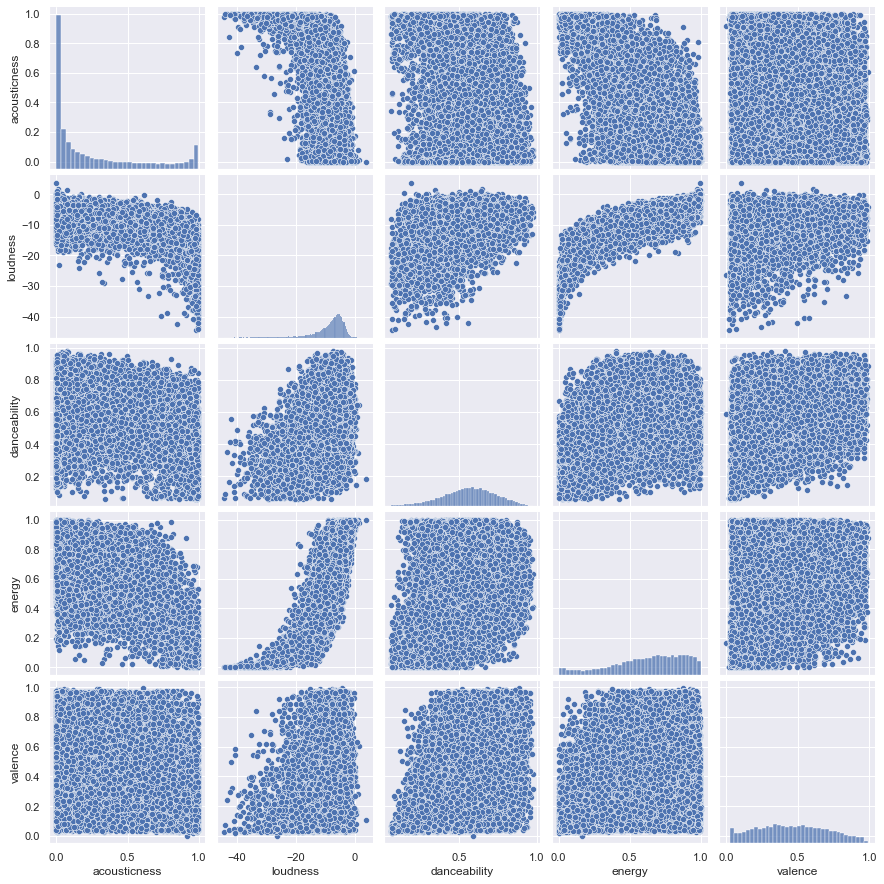

In [23]:
sns.pairplot(train_data[['acousticness', 'loudness', 'danceability', 'energy', 'valence']])
plt.show()

Замечена незначительная зависимость между energy и loudness

In [25]:
temp = train_data.groupby(by='music_genre')[numeric_columns].agg(['mean', 'std'])
temp

instance_id               acousticness           danceability  \
                     mean           std         mean       std         mean   
music_genre                                                                   
Alternative  55889.053825  21138.399899     0.166985  0.246432     0.546601   
Anime        55592.122041  20851.501587     0.269231  0.355200     0.470696   
Blues        55953.698740  20437.704267     0.313793  0.303404     0.526486   
Classical    56364.104151  20418.575102     0.876544  0.248287     0.303564   
Country      56271.025943  20830.460408     0.275042  0.260681     0.578900   
Electronic   56478.887285  20611.263345     0.120547  0.197920     0.618593   
Hip-Hop      56077.265502  20364.421912     0.181786  0.194641     0.718507   
Jazz         56268.140436  20682.823058     0.500227  0.341854     0.582156   
Rap          55367.535008  20625.414654     0.168949  0.190231     0.700364   
Rock         55757.728868  20777.303218     0.197309  0.252931     0.538236   

                         duration_ms                   energy            ...  \
                  std           mean            std      mean       std  ...   
music_genre                                                              ...   
Alternative  0.151513  232373.397155   56289.892357  0.709921  0.208670  ...   
Anime        0.149476  230736.693319   75368.688853  0.675377  0.296484  ...   
Blues        0.142815  250402.112316  106050.566143  0.614087  0.226010  ...   
Classical    0.136257  306841.816460  201704.001508  0.174565  0.221744  ...   
Country      0.110304  218167.219811   42198.360375  0.636092  0.197767  ...   
Electronic   0.148291  266032.324493  155441.258030  0.738151  0.189406  ...   
Hip-Hop      0.133924  217584.388646   55554.501655  0.644582  0.152058  ...   
Jazz         0.159978  264497.715900  114227.266850  0.471680  0.238858  ...   
Rap          0.139189  219779.924217   54245.492553  0.652091  0.155674  ...   
Rock         0.133381  238018.884065   63234.551215  0.683546  0.202249  ...   

             liveness             loudness           speechiness            \
                 mean       std       mean       std        mean       std   
music_genre                                                                  
Alternative  0.197854  0.152612  -6.561434  2.807837    0.089523  0.093543   
Anime        0.195141  0.140771  -7.786926  6.087847    0.064753  0.052522   
Blues        0.237001  0.224826  -8.956438  3.732968    0.061485  0.055880   
Classical    0.168227  0.157493 -21.596170  7.604183    0.052611  0.045124   
Country      0.184424  0.149421  -7.325348  3.208588    0.050289  0.052910   
Electronic   0.208292  0.174173  -6.999542  3.635829    0.099440  0.099457   
Hip-Hop      0.199918  0.150517  -6.844419  2.493319    0.208791  0.131309   
Jazz         0.172556  0.144433 -11.333801  4.603951    0.070873  0.073113   
Rap          0.196734  0.150523  -6.649265  2.405704    0.187334  0.132055   
Rock         0.189246  0.154014  -7.303069  3.312589    0.053498  0.041077   

                  tempo              valence            
                   mean        std      mean       std  
music_genre                                             
Alternative  122.883941  30.043091  0.449189  0.217060  
Anime        126.519026  32.519993  0.435991  0.245993  
Blues        121.323762  29.835964  0.577765  0.222566  
Classical    103.598232  31.059972  0.208213  0.195854  
Country      123.143201  29.706053  0.539644  0.221819  
Electronic   126.297868  26.791951  0.388386  0.238425  
Hip-Hop      120.439077  29.948087  0.473525  0.218268  
Jazz         111.604654  28.435729  0.503369  0.249328  
Rap          119.848388  28.819858  0.456786  0.215460  
Rock         122.359878  28.957109  0.519957  0.233229  

[10 rows x 22 columns]

In [26]:
def genre_variety(genre_1, genre_2, axis_1, axis_2):
    sns.set(rc={'figure.figsize':(18, 12)})
    for genre in [genre_1, genre_2]:
        plt.scatter(x=train_data[train_data['music_genre'] == genre][axis_1],
                    y=train_data[train_data['music_genre'] == genre][axis_2], label = genre)
        plt.xlabel(axis_1)
        plt.ylabel(axis_2)
    plt.legend()
    plt.show()

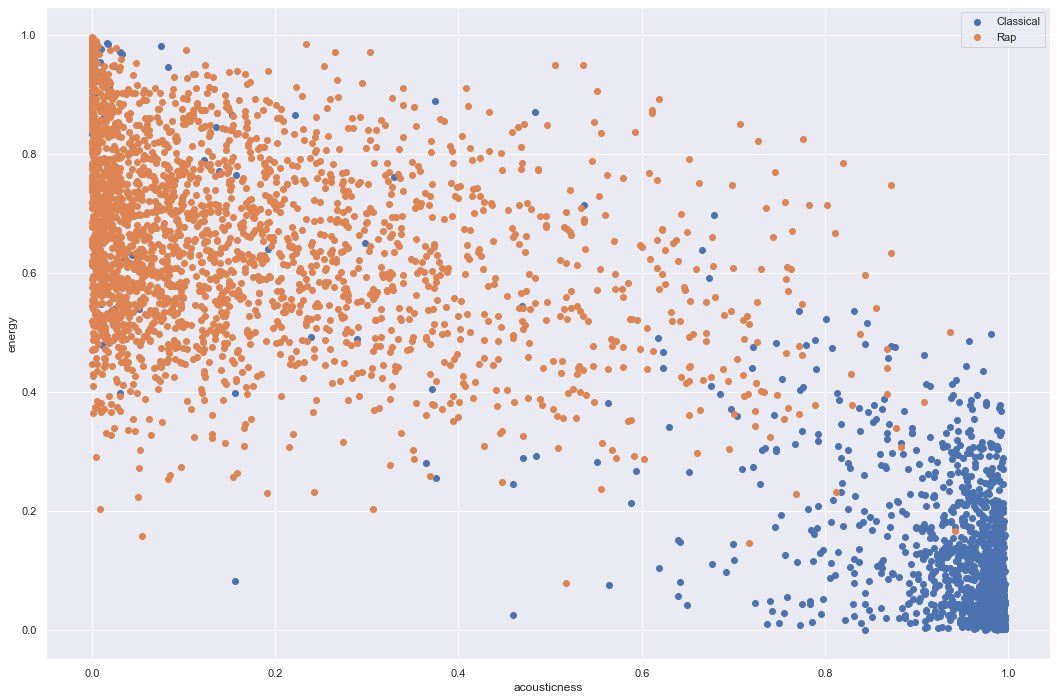

In [27]:
genre_variety('Classical', 'Rap', 'acousticness', 'energy')

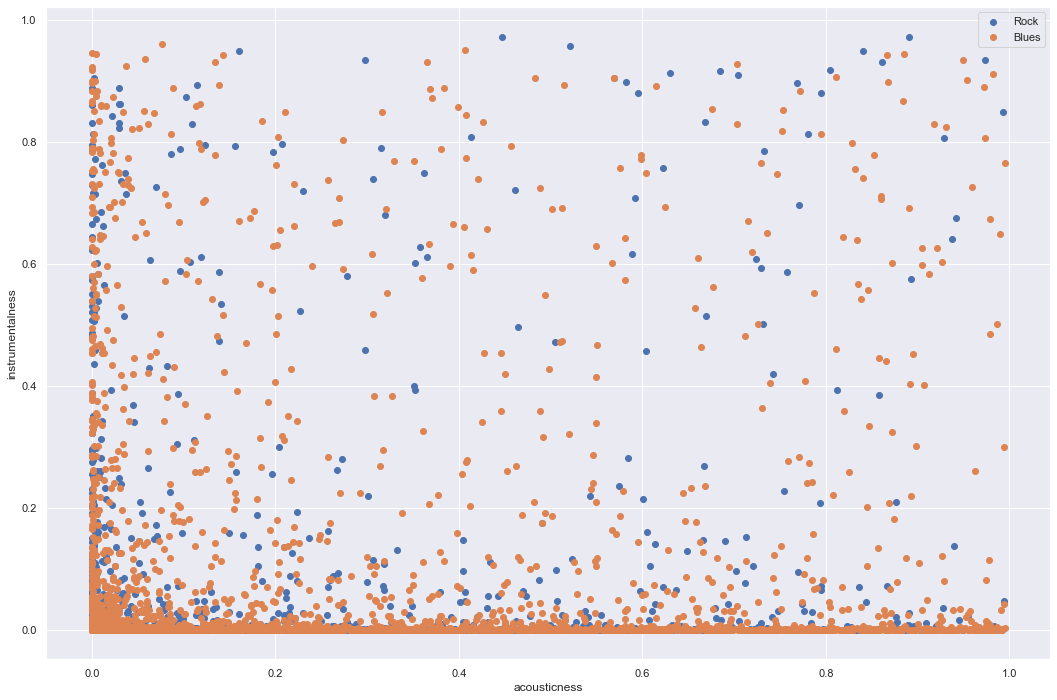

In [28]:
genre_variety('Rock', 'Blues', 'acousticness', 'instrumentalness')

По соотношению mean/std заметно, деление классов весма затруднительно: несмотря на возможность подобрать удачные пары классов и признаков в частном случае (например, Classical и Rap с признаками acousticness и energy) данный принцип не является универсальным, что подтверждает второй график, где сравниваются жанры Rock и Blues.

# Поиск оптимальной модели

Для обучения модели испробуем алгоритмы RandomForest и логистическую регрессию.

In [40]:
X = train_data.drop(columns = ['music_genre', 'track_name'])
y = train_data['music_genre'].replace({'Blues':0,
                               'Alternative':1,
                               'Electronic':2,
                               'Rap':3,
                               'Rock':4,
                               'Country':5,
                               'Anime':6,
                               'Classical':7,
                               'Jazz':8,
                               'Hip-Hop':9})
model = RandomForestClassifier(random_state = 42, class_weight = "balanced")
enc = TargetEncoder()
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipe = Pipeline(steps=[("enc", enc), ("RF", model)])
params = {"RF__n_estimators" : np.arange(120, 241, 10),
          "RF__max_depth" : np.arange(20, 41, 10)}
gs_1 = GridSearchCV(estimator = pipe,
                    param_grid = params,
                    scoring = 'f1_micro',
                    refit = True,
                    cv = skf,
                    verbose = 2,
                    error_score="raise")
gs_1.fit(X, y)
gs_1.best_score_

Fitting 3 folds for each of 39 candidates, totalling 117 fits
[CV] RF__max_depth=20, RF__n_estimators=120 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... RF__max_depth=20, RF__n_estimators=120, total=   4.5s
[CV] RF__max_depth=20, RF__n_estimators=120 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] ........... RF__max_depth=20, RF__n_estimators=120, total=   4.0s
[CV] RF__max_depth=20, RF__n_estimators=120 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=120, total=   4.0s
[CV] RF__max_depth=20, RF__n_estimators=130 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=130, total=   4.3s
[CV] RF__max_depth=20, RF__n_estimators=130 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=130, total=   4.4s
[CV] RF__max_depth=20, RF__n_estimators=130 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=130, total=   4.4s
[CV] RF__max_depth=20, RF__n_estimators=140 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=140, total=   4.7s
[CV] RF__max_depth=20, RF__n_estimators=140 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=140, total=   4.7s
[CV] RF__max_depth=20, RF__n_estimators=140 ..........................
[CV] .

[CV] ........... RF__max_depth=30, RF__n_estimators=180, total=   6.2s
[CV] RF__max_depth=30, RF__n_estimators=190 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=190, total=   6.5s
[CV] RF__max_depth=30, RF__n_estimators=190 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=190, total=   6.5s
[CV] RF__max_depth=30, RF__n_estimators=190 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=190, total=   6.5s
[CV] RF__max_depth=30, RF__n_estimators=200 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=200, total=   6.8s
[CV] RF__max_depth=30, RF__n_estimators=200 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=200, total=   6.8s
[CV] RF__max_depth=30, RF__n_estimators=200 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=200, total=   6.8s
[CV] RF__max_depth=30, RF__n_estimators=210 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed: 12.3min finished


0.46297930763950185

In [41]:
gs_1.best_params_

{'RF__max_depth': 40, 'RF__n_estimators': 240}

Лучший показатель оказался на уровне 0,463. Зафиксируем лучшие параметры для случайного леса: {'RF__max_depth': 40, 'RF__n_estimators': 240}

In [47]:
ct = ColumnTransformer([('scale', StandardScaler(),
                         make_column_selector(dtype_include=np.number)),
                        ('onehot', OneHotEncoder(drop = 'first'),
                         [column for column in X.columns if X[column].dtype == 'object'])])

model = LogisticRegression(random_state = 42,
                           class_weight='balanced',
                           multi_class='ovr',
                           solver='liblinear',
                           penalty='l1')

pipe = Pipeline(steps=[("ct", ct), ("LR", model)])
params = {"LR__C" : np.arange(0.1, 2.01, 0.1)}

gs_2 = GridSearchCV(estimator = pipe,
                    param_grid = params,
                    scoring = 'f1_micro',
                    refit = True,
                    cv = 3,
                    verbose = 2,
                    error_score="raise")
gs_2.fit(X, y)
gs_2.best_score_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] LR__C=0.1 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................ LR__C=0.1, total=   0.4s
[CV] LR__C=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ........................................ LR__C=0.1, total=   0.4s
[CV] LR__C=0.1 .......................................................
[CV] ........................................ LR__C=0.1, total=   0.4s
[CV] LR__C=0.2 .......................................................
[CV] ........................................ LR__C=0.2, total=   0.4s
[CV] LR__C=0.2 .......................................................
[CV] ........................................ LR__C=0.2, total=   0.4s
[CV] LR__C=0.2 .......................................................
[CV] ........................................ LR__C=0.2, total=   0.4s
[CV] LR__C=0.30000000000000004 .......................................
[CV] ........................ LR__C=0.30000000000000004, total=   0.4s
[CV] LR__C=0.30000000000000004 .......................................
[CV] ........................ LR__C=0.30000000000000004, total=   0.4s
[CV] LR__C=0.30000000000000004 .......................................
[CV] .

[CV] ........................................ LR__C=2.0, total=   0.5s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   28.1s finished


0.3917818966362656

0,392! Качество регрессии значительно уступает случайному лесу.

# Новые признаки

При обучении моделей мы получили качество, оставляющее желать лучшего, поэтому попробуем сконструировать новые признаки и обучить модели снова. Идея новых признаков состоит в допущении того, что название трека может иметь корреляцию с жанром, так как некоторые названия (слова) могут быть использованы в качестве признака того или иного жанра. Например слово feat наиболее часто встрачется в популярных современных жанрах типа рэпа, хип-хопа или электроники, а слово no (номер) характерно для классики. 

In [48]:
train_data[train_data['track_name'].str.contains('feat')]['music_genre'].value_counts(normalize = True)

Rap            0.371012
Electronic     0.197812
Hip-Hop        0.166819
Alternative    0.112124
Country        0.051048
Blues          0.026436
Rock           0.025524
Anime          0.020055
Jazz           0.020055
Classical      0.009116
Name: music_genre, dtype: float64

In [49]:
train_data[train_data['track_name'].str.contains('no')]['music_genre'].value_counts(normalize = True)

Classical      0.419547
Anime          0.116806
Electronic     0.084625
Blues          0.081049
Rock           0.069130
Rap            0.060787
Alternative    0.048868
Country        0.048868
Jazz           0.046484
Hip-Hop        0.023838
Name: music_genre, dtype: float64

Для исслеования предлагается выбрать 30 слов, которые наиболее часто встречаются среди списка композиций, предварительно удалив лишние символы

In [52]:
train_data['track_name'] = train_data['track_name'].str.lower()
test_data['track_name'] = test_data['track_name'].str.lower()

In [54]:
lst = [' '.join(list(set(item.split(' ')))) for item in train_data['track_name'].values]
st = " ".join(lst)
st = st.replace('(', '')
st = st.replace(')', '')
st = st.replace('  ', ' ')
st = st.replace("'", "")
st = st.replace(".", "")
st = st.replace(",", "")
train_data['track_name'] = (train_data['track_name']
                    .str.replace('(', '')
                    .str.replace(')', '')
                    .str.replace("'", "")
                    .str.replace(".", "")
                    .str.replace(",", ""))
test_data['track_name'] = (test_data['track_name']
                         .str.replace('(', '')
                         .str.replace(')', '')
                         .str.replace("'", "")
                         .str.replace(".", "")
                         .str.replace(",", ""))

In [60]:
counter = Counter(st.split(' '))
lst = [item[0] for item in counter.most_common(30) if len(item[0])>1]
print(lst)

['the', 'in', 'feat', 'you', 'of', 'me', 'no', 'to', 'my', 'love', 'live', 'on', 'it', 'remix', 'remastered', 'and', 'version', 'for', 'op', 'up', 'all', 'from', 'your', 'with', 'major', 'is']


In [61]:
for item in lst:
    train_data['c_'+item] = np.where(train_data['track_name'].str.contains(item), 1, 0)
    test_data['c_'+item] = np.where(test_data['track_name'].str.contains(item), 1, 0)
numeric_columns = train_data.columns[np.where(train_data.dtypes==np.number)]

Снова попробуем случайный лес и логистическую регрессию

In [63]:
model = RandomForestClassifier(random_state = 42, class_weight = "balanced")
enc = TargetEncoder()

pipe = Pipeline(steps=[("enc", enc), ("RF", model)])
params = {"RF__n_estimators" : np.arange(120, 241, 10),
          "RF__max_depth" : np.arange(20, 41, 10)}
gs_1 = GridSearchCV(estimator = pipe,
                    param_grid = params,
                    scoring = 'f1_micro',
                    refit = True,
                    cv = skf,
                    verbose = 2,
                    error_score="raise")
gs_1.fit(X, y)
gs_1.best_score_

Fitting 3 folds for each of 39 candidates, totalling 117 fits
[CV] RF__max_depth=20, RF__n_estimators=120 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... RF__max_depth=20, RF__n_estimators=120, total=   3.7s
[CV] RF__max_depth=20, RF__n_estimators=120 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] ........... RF__max_depth=20, RF__n_estimators=120, total=   3.6s
[CV] RF__max_depth=20, RF__n_estimators=120 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=120, total=   3.5s
[CV] RF__max_depth=20, RF__n_estimators=130 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=130, total=   3.8s
[CV] RF__max_depth=20, RF__n_estimators=130 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=130, total=   3.8s
[CV] RF__max_depth=20, RF__n_estimators=130 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=130, total=   3.8s
[CV] RF__max_depth=20, RF__n_estimators=140 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=140, total=   4.1s
[CV] RF__max_depth=20, RF__n_estimators=140 ..........................
[CV] ........... RF__max_depth=20, RF__n_estimators=140, total=   4.2s
[CV] RF__max_depth=20, RF__n_estimators=140 ..........................
[CV] .

[CV] ........... RF__max_depth=30, RF__n_estimators=180, total=   5.9s
[CV] RF__max_depth=30, RF__n_estimators=190 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=190, total=   6.1s
[CV] RF__max_depth=30, RF__n_estimators=190 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=190, total=   6.1s
[CV] RF__max_depth=30, RF__n_estimators=190 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=190, total=   6.3s
[CV] RF__max_depth=30, RF__n_estimators=200 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=200, total=   6.6s
[CV] RF__max_depth=30, RF__n_estimators=200 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=200, total=   6.5s
[CV] RF__max_depth=30, RF__n_estimators=200 ..........................
[CV] ........... RF__max_depth=30, RF__n_estimators=200, total=   6.6s
[CV] RF__max_depth=30, RF__n_estimators=210 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed: 11.4min finished


0.4764146317544376

In [64]:
gs_1.best_params_

{'RF__max_depth': 40, 'RF__n_estimators': 140}

Лучший показатель оказался на уровне 0,476 против 0,463 до введения дополнительных признаков. Зафиксируем лучшие параметры для случайного леса: {'RF__max_depth': 40, 'RF__n_estimators': 140}

In [65]:
ct = ColumnTransformer([('scale', StandardScaler(),
                         make_column_selector(dtype_include=np.number)),
                        ('onehot', OneHotEncoder(drop = 'first'),
                         [column for column in X.columns if X[column].dtype == 'object'])])

model = LogisticRegression(random_state = 42,
                           class_weight='balanced',
                           multi_class='ovr',
                           solver='liblinear',
                           penalty='l1')

pipe = Pipeline(steps=[("ct", ct), ("LR", model)])
params = {"LR__C" : np.arange(0.1, 2.01, 0.1)}

gs_2 = GridSearchCV(estimator = pipe,
                    param_grid = params,
                    scoring = 'f1_micro',
                    refit = True,
                    cv = 3,
                    verbose = 2,
                    error_score="raise")
gs_2.fit(X, y)
gs_2.best_score_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] LR__C=0.1 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................ LR__C=0.1, total=   1.5s
[CV] LR__C=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ........................................ LR__C=0.1, total=   1.4s
[CV] LR__C=0.1 .......................................................
[CV] ........................................ LR__C=0.1, total=   1.3s
[CV] LR__C=0.2 .......................................................
[CV] ........................................ LR__C=0.2, total=   1.7s
[CV] LR__C=0.2 .......................................................
[CV] ........................................ LR__C=0.2, total=   1.7s
[CV] LR__C=0.2 .......................................................
[CV] ........................................ LR__C=0.2, total=   1.6s
[CV] LR__C=0.30000000000000004 .......................................
[CV] ........................ LR__C=0.30000000000000004, total=   2.1s
[CV] LR__C=0.30000000000000004 .......................................
[CV] ........................ LR__C=0.30000000000000004, total=   2.0s
[CV] LR__C=0.30000000000000004 .......................................
[CV] .

[CV] ........................................ LR__C=2.0, total=   2.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.1min finished


0.400411885848779

0,4 против 0,392, качество регрессии выросло совсем незначительно и по-прежнему значительно уступает случайному лесу.

Как видно в представленных расчётов конструирование признаков позволило незначительно повысить качество по каждой из моделей: примерно на 0.008 - 0.013 в каждом из алгоритмов.

## Общий вывод

- Данные загружены, обработаны явные и неявные пропуски
- Проанализированы распределения и корреляции признаков
- Подготовлены модели RandomForest и LogisticRegression
- Для улучшения качества были разработаны дополнительные признаки из названия треков, это позволило улучшить качество примерно на 0.01
